In [1]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import glob
from collections import Counter


def stat_parity_rank_func(df, epoch_columns):
    # calculate the violation of statistical parity
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df[epoch_columns]==0).sum(axis=0)/g_df.shape[0]
    return abs(data['male'] - data['female'])

def preprocess_df(df):
    if df.columns[1:][0]=="epoch_1":
        li = ["ids"] 
        for i in range(0,len(df.columns[1:])):
            li.append("epoch_"+str(i))
        df.columns = li
        return df
    else:
        return df
def acc_by_gender(df):
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = g_df['rank_by_id'].sum(axis=0)/g_df.shape[0]
    return data['male'],data['female']

def stat_parity_func(df, epoch_columns):
    # calculate the violation of statistical parity
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df[epoch_columns]==0).sum(axis=0)/g_df.shape[0]
    return abs(data['male'] - data['female'])

def stat_parity_ratio_func(df, epoch_columns):
    # calculate the violation of statistical parity
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df[epoch_columns]==0).sum(axis=0)/g_df.shape[0]
    return np.abs(1-data['male']/data['female'])

def stat_parity_ratio_rank_func(df, epoch_columns):
    # calculate the violation of statistical parity
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df[epoch_columns]==0).sum(axis=0)/g_df.shape[0]
    return np.abs(1-data['male']/data['female'])

def ratio_errors_func(df, epoch_columns):
    # calculate the violation of statistical parity
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df[epoch_columns]!=0).sum(axis=0)/g_df.shape[0]
    return np.abs(1-data['male']/data['female'])

def stat_parity_from_rank_ratio_func(df, epoch_columns):
    # calculate the violation of statistical parity
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df[epoch_columns] == 0).sum(axis=0)/g_df.shape[0]
    return np.abs(1-data['male']/data['female'])

def rank_func(df, epoch_columns):
    # calculate the violation of statistical parity
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df[epoch_columns]).sum(axis=0)/g_df.shape[0]
    return abs(data['male']-data['female'])

def rank_ratio_func(df, epoch_columns):
    # calculate the violation of statistical parity
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df[epoch_columns]).sum(axis=0)/g_df.shape[0]
    return np.abs(1-data['male']/data['female'])

def acc_func(df, epoch_columns):
    # calculate the accuracy 
    return df[epoch_columns].sum(axis=0)/df.shape[0]

def acc_from_rank_func(df, epoch_columns):
    # calculate the accuracy 
    return (df[epoch_columns] == 0).sum(axis=0)/df.shape[0]

def acc_by_gender(df):
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = g_df['rank_by_id'].sum(axis=0)/g_df.shape[0]
    return data['male']
def acc_from_rank_func_male(df, epoch_columns):
    # calculate the accuracy 
    return (df[epoch_columns] == 0).sum(axis=0)/df.shape[0]

def err_from_rank_func(df, epoch_columns):
    # calculate the accuracy 
    return (df[epoch_columns] != 0).sum(axis=0)/df.shape[0]

def get_name_details(f):
    head_id = -4 if 'cosine' in f else -2
    opt_id = -3 if 'cosine' in f else -1
    y = os.path.splitext(os.path.basename(f))[0]
    experiment = y.replace('config_','')
    head = experiment.split('_')[head_id]
    opt = experiment.split('_')[opt_id]
    model = '_'.join(experiment.split('_')[:head_id])
    return experiment, model, head, opt


def analyze_files(files, metadata, ratio=False, error=False, epochs=None):
    acc_df = pd.DataFrame(columns=['epoch_'+str(e) for e in range(100)])
    acc_disp_df = pd.DataFrame(columns=['epoch_'+str(e) for e in range(100)])
    for f in files:
        try:
            df = pd.read_csv(f)
            #df  = preprocess_df(df)
        except:
            continue
        epoch_columns = df.drop('ids',axis=1).columns
        df = metadata.merge(df)
        num_epochs = len(epoch_columns)
        df[epoch_columns] = df[epoch_columns].apply(lambda x: x == df['label'])
        acc = acc_func(df, epoch_columns)
        experiment = get_name_details(f)[0]
        acc_df.loc[experiment] = acc
        if ratio:
            if error:
                acc_disp = ratio_errors_func(df, epoch_columns)
            else:
                acc_disp = stat_parity_ratio_func(df, epoch_columns)
        else:
            acc_disp = stat_parity_func(df, epoch_columns)
        acc_disp_df.loc[experiment] = acc_disp    
    return acc_df, acc_disp_df

def analyze_rank_files_np(files, metadata, ratio=False, error=False, epochs=None): 
    if epochs is None:
        epochs = ['epoch_'+str(e) for e in range(101)]
        
    acc_df = pd.DataFrame(columns=epochs)
    acc_ratio_df = pd.DataFrame(columns=epochs)
    rank_df = pd.DataFrame(columns=epochs)
    male =[]
    female = []
    for f in files:
        try:
            df = pd.read_csv(f)
            #df  = preprocess_df(df)
        except:
            print(f)
            print("here")
            continue
        epoch_columns = list(set(df.columns).intersection(epochs))
        df = metadata.merge(df)
        num_epochs = len(epoch_columns)
        if error:
            acc = err_from_rank_func(df, epoch_columns)
        else:
            acc = acc_from_rank_func(df, epoch_columns)
        experiment = f.split('/')[0]
        acc_df.loc[experiment] = acc
        
        if ratio:
            if error:
                acc_disp = ratio_errors_func(df, epoch_columns)
            else:
                acc_disp = stat_parity_ratio_rank_func(df, epoch_columns)
        else:
            acc_disp = stat_parity_rank_func(df, epoch_columns)
        acc_ratio_df.loc[experiment] = acc_disp 
        
        if ratio:
            rank_ratio = rank_ratio_func(df, epoch_columns)
        else:
            rank_ratio = rank_func(df, epoch_columns)
        rank_df.loc[experiment] = rank_ratio  
    return acc_df, acc_ratio_df, rank_df

def analyze_rank_files(files, metadata, ratio=False, error=False, epochs=None): 
    acc_df, acc_ratio_df, rank_df = analyze_rank_files_np(files, metadata, ratio=ratio, error=error, epochs=epochs)
    return prepare(acc_df), prepare(acc_ratio_df), prepare(rank_df)

def plot_df(acc_df, acc_disp_df, rank_df = None, title = ''):
    def prepare(df):
        # dataframe of a long format
        df = pd.melt(df.reset_index(), id_vars='index')
        df = df.rename(columns={'variable':'epoch'})
        df = df.rename(columns={'value':'Accuracy'})
        df.epoch = df.epoch.apply(lambda x: int(x.split('_')[1]))
        return df
    acc_df = prepare(acc_df)
    acc_disp_df = prepare(acc_disp_df)

    # plotly express
    acc_df['measurement'] = 'Accuracy'
    acc_disp_df['measurement'] = 'Disparity'

    df = acc_df.append(acc_disp_df)

    if rank_df is not None:
        rank_df = prepare(rank_df)
        rank_df['measurement'] = 'Rank'
        df = df.append(rank_df)
        
    df = df.dropna()

    fig = px.line(df, x='epoch', y='Accuracy', color='index', facet_row='measurement', title=title)
    fig.update_yaxes(matches=None)
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.update_layout(yaxis_title="Disparity")

    fig.show()
    
    
def whatIsPareto(df, x_inc=False, y_inc=False):
    isPareto = np.zeros(df.shape[0])
    i = 0
    for _, (c1,c2) in df.iterrows():
        tmp = np.delete(np.array(df), (i), axis=0)
        if x_inc: # is a larger x better?
            if y_inc: # is a larger y better?
                b = np.any(np.apply_along_axis(lambda x: x[0]>c1 and x[1]>c2, 1, tmp))
            else: # is a smaller y better?
                b = np.any(np.apply_along_axis(lambda x: x[0]>c1 and x[1]<c2, 1, tmp))
        else: # is a smaller x better?
            if y_inc: # is a larger y better?
                b = np.any(np.apply_along_axis(lambda x: x[0]<c1 and x[1]>c2, 1, tmp))
            else: # is a smaller y better?
                b = np.any(np.apply_along_axis(lambda x: x[0]<c1 and x[1]<c2, 1, tmp))
        if not b:
            isPareto[i] = 1
        i+=1
    return isPareto

def preparePareto(df, x_inc=False, y_inc=False):
    
    isPareto = whatIsPareto(df, x_inc=x_inc, y_inc=y_inc)
    tmp = df[isPareto == 1]
    
    tmp = tmp.sort_values(df.columns[0])
    return tmp

def prepare(df):
    # dataframe of a long format
    #print(df.head())
    df = pd.melt(df.reset_index(), id_vars='index')
    df = df.rename(columns={'variable':'epoch'})
    df = df.rename(columns={'value':'Metric'})
    df.epoch = df.epoch.apply(lambda x: int(x.split('_')[1]))
    return df

def merge(df1, df2):
    df = df1.merge(df2, on=["index","epoch"])
    df = df.rename(columns={'Metric_x':'Accuracy'})
    df = df.rename(columns={'Metric_y':'Disparity'})
    return df

def drop_models(df_list, models):
    # remove rows with model names in models from each df in the df_list
    out_list = []
    for df in df_list:
        out_list += [df[~df['index'].isin(models)]]
    return out_list


def find_yaml_folder(yaml):
    '''
    given a yaml string file like:
         'config_inception_resnet_v2_CosFace_RMSProp.yaml'
    return the corresponding folder for this experiment:
         './Phase1B/inception_resnet_v2_CosFace_RMSProp'
    if it does not exist, return ''
    '''
    experiment_name = yaml.replace('config_','').replace('.yaml','')

    experiment_folders = glob.glob('/cmlscratch/sdooley1/merge_timm/FR-NAS/Checkpoints/Phase1B/*') + glob.glob('/cmlscratch/sdooley1/merge_timm/FR-NAS/Checkpoints/timm_explore_few_epochs/*')
    where = [get_name_details(experiment_name)[0].lower() == get_name_details(x)[0].lower() for x in experiment_folders]
    yaml_folder = ''
    if any(where):
        yaml_folder = experiment_folders[np.where(where)[0][0]]
    return yaml_folder

def get_finished_models_Phase1B():
    '''
    Return a list of those models which we are including in Phase1B
    '''
    finished = []
    for yaml_orig in glob.glob('/cmlscratch/sdooley1/merge_timm/FR-NAS/configs/**/*.yaml') + glob.glob('/cmlscratch/sdooley1/merge_timm/FR-NAS/configs_multi/**/*.yaml'):
        yaml = os.path.basename(yaml_orig)
        yaml_folder = find_yaml_folder(yaml)
        if yaml_folder:
            finished += [yaml]
    cn = Counter([get_name_details(x)[1] for x in finished])
    final_models = [k for k,v in cn.items() if v>=6]
    final_models.sort()

    return final_models


def get_pareto_hps_head_opt(stable_df, col='Accuracy'):
    row = []
    for opt in ['adamw', 'sgd']:
        for head in ['ArcFace','CosFace','MagFace']:
            df = stable_df
            df = df[(df['opt'] == opt) & (df['head'] == head)]
            ind = whatIsPareto(df[[col,'Disparity']], True, False).astype(bool)
            out = df[ind].dropna().sort_values(col, ascending=False)
            m = out['model'].to_string(header=False,index=False).split('\n')
            row += ['\n'.join(list(np.unique([x.strip() for x in m])))]
    return row

def get_pareto_hps_opt(stable_df, col='Accuracy'):
    row = []
    for opt in ['adamw', 'sgd']:
            df = stable_df
            df = df[(df['opt'] == opt)]
            ind = whatIsPareto(df[[col,'Disparity']], True, False).astype(bool)
            out = df[ind].dropna().sort_values(col, ascending=False)
            m = out['model'].to_string(header=False,index=False).split('\n')
            row += ['\n'.join(list(np.unique([x.strip() for x in m])))]
    return row

def get_pareto_hps_head(stable_df, col='Accuracy'):
    row = []
    for head in ['ArcFace', 'CosFace', 'MagFace']:
            df = stable_df
            df = df[(df['head'] == head)]
            ind = whatIsPareto(df[[col,'Disparity']], True, False).astype(bool)
            out = df[ind].dropna().sort_values(col, ascending=False)
            m = out['model'].to_string(header=False,index=False).split('\n')
            row += ['\n'.join(list(np.unique([x.strip() for x in m])))]
    return row

def anova_hp_accuracy(df, col = 'Accuracy'):
    df['model'] = df['index'].apply(lambda x: get_name_details(x.replace('_rank_by_id_val',''))[1])
    df['head'] = df['index'].apply(lambda x: get_name_details(x.replace('_rank_by_id_val',''))[2])
    df['opt'] = df['index'].apply(lambda x: get_name_details(x.replace('_rank_by_id_val',''))[3].lower())
    df = df.merge(meta, left_on='model', right_on='model_name')
    df.fillna('0',inplace=True)
    df[col] = df[col].astype(float)

    lm = ols(col+' ~ head + opt', data=df).fit() # fitting the model
    
    print(sm.stats.anova_lm(lm))
    tukey_head = pairwise_tukeyhsd(endog=df[col],
                              groups=df['head'],
                              alpha=0.05)
    print(tukey_head)
    tukey_opt = pairwise_tukeyhsd(endog=df[col],
                              groups=df['opt'],
                              alpha=0.05)
    print(tukey_opt)
    
    return sm.stats.anova_lm(lm), tukey_head, tukey_opt

def anova_hp_disp(df, col = 'Accuracy'):
    df['model'] = df['index'].apply(lambda x: get_name_details(x.replace('_rank_by_id_val',''))[1])
    df['head'] = df['index'].apply(lambda x: get_name_details(x.replace('_rank_by_id_val',''))[2])
    df['opt'] = df['index'].apply(lambda x: get_name_details(x.replace('_rank_by_id_val',''))[3].lower())
    df = df.merge(meta, left_on='model', right_on='model_name')
    df.fillna('0',inplace=True)
    df['Disparity'] = df['Disparity'].astype(float)

    lm = ols('Disparity ~ head + opt', data=df).fit() # fitting the model
    
    print(sm.stats.anova_lm(lm))
    tukey_head = pairwise_tukeyhsd(endog=df['Disparity'],
                              groups=df['head'],
                              alpha=0.05)
    print(tukey_head)
    tukey_opt = pairwise_tukeyhsd(endog=df['Disparity'],
                              groups=df['opt'],
                              alpha=0.05)
    print(tukey_opt)
    
    return sm.stats.anova_lm(lm), tukey_head, tukey_opt

In [2]:
#Plot male v/s female accuracy
import os
# os.chdir('..')
metadata = pd.read_csv('val_identities_gender-expression_seed_222.csv')
os.chdir('Checkpoints_scratch/')
import pandas as pd
import numpy as np
import os
import glob

rank_files = glob.glob('*/*_rank_by_id_val.csv')
#print(kacc_files)

epochs = ['epoch_'+str(i) for i in [19,39,59,79,99]]
acc_df, acc_disp_df, rank_df = analyze_rank_files(rank_files, metadata, epochs=epochs)
_, acc_disp_ratio_df, rank_ratio_df = analyze_rank_files(rank_files, metadata, ratio=True, epochs=epochs)
err_df, error_ratio_df, _ = analyze_rank_files(rank_files, metadata, ratio=True, error=True, epochs=epochs)

In [195]:
def spearman(x,y):
    return scipy.stats.spearmanr(x,y)[0]
def kendall(x,y):
    return scipy.stats.kendalltau(x,y)[0]
def pearson(x,y):
    return scipy.stats.pearsonr(x,y)[0]

def return_correlations(x,y):
    return {"spearman":spearman(x,y),"kendall":kendall(x,y),"pearson":pearson(x,y)}



In [196]:
def get_df_pareto(df,epoch):
    df_rank =df[df["epoch"]==epoch].dropna()
    new_df = pd.DataFrame(columns=df_rank.columns)
    mobnet = df_rank[df_rank["index"].str.contains(r'mobilenetv3_large_100_CosFace_SGD_0.1_cosine*')]
    new_df = new_df.append({"epoch":epoch,"index":"mobilenetv3_large_100_CosFace_SGD_0.1_cosine","Accuracy":np.mean(mobnet["Accuracy"]),"Disparity":np.mean(mobnet["Disparity"])},ignore_index=True)
    tnt = df_rank[df_rank["index"].str.contains(r'tnt_s_patch16_224_CosFace_AdamW*')]
    new_df = new_df.append({"epoch":epoch,"index":"tnt_s_patch16_224_CosFace_AdamW","Accuracy":np.mean(tnt["Accuracy"]),"Disparity":np.mean(tnt["Disparity"])},ignore_index=True)
    rexnet = df_rank[df_rank["index"].str.contains(r'rexnet_200_MagFace_SGD_0.1_cosine*')]
    new_df = new_df.append({"epoch":epoch,"index":"rexnet_200_MagFace_SGD_0.1_cosine","Accuracy":np.mean(rexnet["Accuracy"]),"Disparity":np.mean(rexnet["Disparity"])},ignore_index=True)
    inception = df_rank[df_rank["index"].str.contains(r'inception_resnet_v2_CosFace_AdamW_0.001_cosine*')]
    new_df = new_df.append({"epoch":epoch,"index":"inception_resnet_v2_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(inception["Accuracy"]),"Disparity":np.mean(inception["Disparity"])},ignore_index=True)
    ese = df_rank[df_rank["index"].str.contains(r'ese_vovnet39b_CosFace_AdamW_0.001_cosine*')]
    new_df = new_df.append({"epoch":epoch,"index":"ese_vovnet39b_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(ese["Accuracy"]),"Disparity":np.mean(ese["Disparity"])},ignore_index=True)
    densenet161 = df_rank[df_rank["index"].str.contains(r'densenet161_CosFace_AdamW_0.001_cosine*')]
    new_df = new_df.append({"epoch":epoch,"index":"densenet161_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(densenet161["Accuracy"]),"Disparity":np.mean(densenet161["Disparity"])},ignore_index=True)
    dpn2 = df_rank[df_rank["index"].str.contains(r'dpn107_MagFace_SGD_0.1_cosine*')]
    new_df = new_df.append({"epoch":epoch,"index":"dpn107_MagFace_SGD_0.1_cosine","Accuracy":np.mean(dpn2["Accuracy"]),"Disparity":np.mean(dpn2["Disparity"])},ignore_index=True)
    dpns=df_rank[df_rank["index"].str.contains(r'dpn107_CosFace_SGD_0.1_cosine*')]
    new_df = new_df.append({"epoch":epoch,"index":"dpn107_CosFace_SGD_0.1_cosine","Accuracy":np.mean(dpns["Accuracy"]),"Disparity":np.mean(dpns["Disparity"])},ignore_index=True)
    model_000=df_rank[df_rank["index"].str.contains(r'Checkpoints_Edges_000*')]
    new_df = new_df.append({"epoch":epoch,"index":"Checkpoints_Edges_000","Accuracy":np.mean(model_000["Accuracy"]),"Disparity":np.mean(model_000["Disparity"])},ignore_index=True)
    model_010=df_rank[df_rank["index"].str.contains(r'Checkpoints_Edges_010*')]
    new_df = new_df.append({"epoch":epoch,"index":"Checkpoints_Edges_010","Accuracy":np.mean(model_010["Accuracy"]),"Disparity":np.mean(model_010["Disparity"])},ignore_index=True)
    model_680=df_rank[df_rank["index"].str.contains(r'Checkpoints_Edges_680*')]
    new_df = new_df.append({"epoch":epoch,"index":"Checkpoints_Edges_680","Accuracy":np.mean(model_680["Accuracy"]),"Disparity":np.mean(model_680["Disparity"])},ignore_index=True)
    return new_df
def get_df_pareto_seed_avg(df,epoch,metric):
    #print(df.shape)
    df_rank = df.copy()
    df_rank =df_rank[df_rank["epoch"]==epoch].dropna()
    #new_df = pd.DataFrame(columns=df.columns)
    mobnet = df_rank[df_rank["index"].str.contains(r'mobilenetv3_large_100_CosFace_SGD_0.1_cosine*')]
    #print(mobnet.index)
    #df_rank = df_rank.append({"epoch":epoch,"index":"mobilenetv3_large_100_CosFace_SGD_0.1_cosine","Accuracy":np.mean(mobnet["Accuracy"]),"Disparity":np.mean(mobnet["Disparity"])},ignore_index=True)
    #print(df_rank.shape)
    df_rank.drop(mobnet.index,inplace=True)
    tnt = df_rank[df_rank["index"].str.contains(r'tnt_s_patch16_224_CosFace_AdamW*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"tnt_s_patch16_224_CosFace_AdamW","Accuracy":np.mean(tnt["Accuracy"]),"Disparity":np.mean(tnt["Disparity"])},ignore_index=True)
    df_rank.drop(tnt.index,inplace=True)
    rexnet = df_rank[df_rank["index"].str.contains(r'rexnet_200_MagFace_SGD_0.1_cosine*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"rexnet_200_MagFace_SGD_0.1_cosine","Accuracy":np.mean(rexnet["Accuracy"]),"Disparity":np.mean(rexnet["Disparity"])},ignore_index=True)
    df_rank.drop(rexnet.index,inplace=True)
    inception = df_rank[df_rank["index"].str.contains(r'inception_resnet_v2_CosFace_AdamW_0.001_cosine*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"inception_resnet_v2_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(inception["Accuracy"]),"Disparity":np.mean(inception["Disparity"])},ignore_index=True)
    df_rank.drop(inception.index,inplace=True)
    ese = df_rank[df_rank["index"].str.contains(r'ese_vovnet39b_CosFace_AdamW_0.001_cosine*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"ese_vovnet39b_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(ese["Accuracy"]),"Disparity":np.mean(ese["Disparity"])},ignore_index=True)
    df_rank.drop(ese.index,inplace=True)
    densenet161 = df_rank[df_rank["index"].str.contains(r'densenet161_CosFace_AdamW_0.001_cosine*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"densenet161_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(densenet161["Accuracy"]),"Disparity":np.mean(densenet161["Disparity"])},ignore_index=True)
    df_rank.drop(densenet161.index,inplace=True)
    dpn2 = df_rank[df_rank["index"].str.contains(r'dpn107_MagFace_SGD_0.1_cosine*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"dpn107_MagFace_SGD_0.1_cosine","Accuracy":np.mean(dpn2["Accuracy"]),"Disparity":np.mean(dpn2["Disparity"])},ignore_index=True)
    df_rank.drop(dpn2.index,inplace=True)
    dpns=df_rank[df_rank["index"].str.contains(r'dpn107_CosFace_SGD_0.1_cosine*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"dpn107_CosFace_SGD_0.1_cosine","Accuracy":np.mean(dpns["Accuracy"]),"Disparity":np.mean(dpns["Disparity"])},ignore_index=True)
    df_rank.drop(dpns.index,inplace=True)
    model_000=df_rank[df_rank["index"].str.contains(r'Checkpoints_Edges_000*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"Checkpoints_Edges_000","Accuracy":np.mean(model_000["Accuracy"]),"Disparity":np.mean(model_000["Disparity"])},ignore_index=True)
    df_rank.drop(model_000.index,inplace=True)
    model_010=df_rank[df_rank["index"].str.contains(r'Checkpoints_Edges_010*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"Checkpoints_Edges_010","Accuracy":np.mean(model_680["Accuracy"]),"Disparity":np.mean(model_010["Disparity"])},ignore_index=True)
    df_rank.drop(model_010.index,inplace=True)
    model_680=df_rank[df_rank["index"].str.contains(r'Checkpoints_Edges_680*')]
    #df_rank = df_rank.append({"epoch":epoch,"index":"Checkpoints_Edges_680","Accuracy":np.mean(model_680["Accuracy"]),"Disparity":np.mean(model_680["Disparity"])},ignore_index=True)
    df_rank.drop(model_680.index,inplace=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"mobilenetv3_large_100_CosFace_SGD_0.1_cosine","Accuracy":np.mean(mobnet["Accuracy"]),metric :np.mean(mobnet[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"tnt_s_patch16_224_CosFace_AdamW","Accuracy":np.mean(tnt["Accuracy"]),metric:np.mean(tnt[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"Checkpoints_Edges_680","Accuracy":np.mean(model_680["Accuracy"]),metric:np.mean(model_680[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"Checkpoints_Edges_010","Accuracy":np.mean(model_010["Accuracy"]),metric:np.mean(model_010[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"Checkpoints_Edges_000","Accuracy":np.mean(model_000["Accuracy"]),metric:np.mean(model_000[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"dpn107_CosFace_SGD_0.1_cosine","Accuracy":np.mean(dpns["Accuracy"]),metric:np.mean(dpns[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"dpn107_MagFace_SGD_0.1_cosine","Accuracy":np.mean(dpn2["Accuracy"]),metric:np.mean(dpn2[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"densenet161_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(densenet161["Accuracy"]),metric:np.mean(densenet161[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"ese_vovnet39b_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(ese["Accuracy"]),metric:np.mean(ese[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"inception_resnet_v2_CosFace_AdamW_0.001_cosine","Accuracy":np.mean(inception["Accuracy"]),metric:np.mean(inception[metric])},ignore_index=True)
    df_rank = df_rank.append({"epoch":epoch,"index":"rexnet_200_MagFace_SGD_0.1_cosine","Accuracy":np.mean(rexnet["Accuracy"]),metric:np.mean(rexnet[metric])},ignore_index=True)
    return df_rank





In [197]:
metric = "Disparity"
df_ratio_errors = merge(err_df, error_ratio_df)
df_rank_ratio= merge(acc_df, rank_ratio_df)
df_ratio = merge(acc_df,acc_disp_ratio_df)
df_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
df_diff = merge(acc_df,acc_disp_df)
df_rank = merge(acc_df, rank_df)
dfs = {"ratio_errors":df_ratio_errors,"rank_ratio":df_rank_ratio,"ratio":df_ratio,"diff":df_diff,"rank":df_rank}
df_correlations = pd.DataFrame(columns=["Metric","Epoch","Spearman","Kendall","Pearson","Pareto"])
for df_name in dfs.keys():
    print(df_name)
    df = dfs[df_name]
    if df_name=="ratio_errors":
        df["Accuracy"]=1-df["Accuracy"] #Flip to get accuracy from error returned
    df_avg_19_p = get_df_pareto(df,19).dropna()
    df_avg_39_p = get_df_pareto(df,39).dropna()
    df_avg_59_p = get_df_pareto(df,59).dropna()
    df_avg_79_p = get_df_pareto(df,79).dropna()
    df_avg_99_p = get_df_pareto(df,99).dropna()
    df_avg_19 = get_df_pareto_seed_avg(df,19,metric).dropna()
    df_avg_39 = get_df_pareto_seed_avg(df,39,metric).dropna()
    df_avg_59 = get_df_pareto_seed_avg(df,59,metric).dropna()
    df_avg_79 = get_df_pareto_seed_avg(df,79,metric).dropna()
    df_avg_99 = get_df_pareto_seed_avg(df,99,metric).dropna()
    corr_avg_19_p = return_correlations(df_avg_19_p["Accuracy"],df_avg_19_p[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":19,"Spearman":corr_avg_19_p["spearman"],"Kendall":corr_avg_19_p["kendall"],"Pearson":corr_avg_19_p["pearson"],"Pareto":True},ignore_index=True)
    corr_avg_39_p = return_correlations(df_avg_39_p["Accuracy"],df_avg_39_p[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":39,"Spearman":corr_avg_39_p["spearman"],"Kendall":corr_avg_39_p["kendall"],"Pearson":corr_avg_39_p["pearson"],"Pareto":True},ignore_index=True)
    corr_avg_59_p = return_correlations(df_avg_59_p["Accuracy"],df_avg_59_p[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":59,"Spearman":corr_avg_59_p["spearman"],"Kendall":corr_avg_59_p["kendall"],"Pearson":corr_avg_59_p["pearson"],"Pareto":True},ignore_index=True)
    corr_avg_79_p = return_correlations(df_avg_79_p["Accuracy"],df_avg_79_p[metric])
    df_correlations= df_correlations.append({"Metric":df_name,"Epoch":79,"Spearman":corr_avg_79_p["spearman"],"Kendall":corr_avg_79_p["kendall"],"Pearson":corr_avg_79_p["pearson"],"Pareto":True},ignore_index=True)
    corr_avg_99_p = return_correlations(df_avg_99_p["Accuracy"],df_avg_99_p[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":99,"Spearman":corr_avg_99_p["spearman"],"Kendall":corr_avg_99_p["kendall"],"Pearson":corr_avg_99_p["pearson"],"Pareto":True},ignore_index=True)
    corr_avg_19 = return_correlations(df_avg_19["Accuracy"],df_avg_19[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":19,"Spearman":corr_avg_19["spearman"],"Kendall":corr_avg_19["kendall"],"Pearson":corr_avg_19["pearson"],"Pareto":False},ignore_index=True)
    corr_avg_39 = return_correlations(df_avg_39["Accuracy"],df_avg_39[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":39,"Spearman":corr_avg_39["spearman"],"Kendall":corr_avg_39["kendall"],"Pearson":corr_avg_39["pearson"],"Pareto":False},ignore_index=True)
    corr_avg_59= return_correlations(df_avg_59["Accuracy"],df_avg_59[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":59,"Spearman":corr_avg_59["spearman"],"Kendall":corr_avg_59["kendall"],"Pearson":corr_avg_59["pearson"],"Pareto":False},ignore_index=True)
    corr_avg_79 = return_correlations(df_avg_79["Accuracy"],df_avg_79[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":79,"Spearman":corr_avg_79["spearman"],"Kendall":corr_avg_79["kendall"],"Pearson":corr_avg_79["pearson"],"Pareto":False},ignore_index=True)
    corr_avg_99 = return_correlations(df_avg_99["Accuracy"],df_avg_99[metric])
    df_correlations = df_correlations.append({"Metric":df_name,"Epoch":99,"Spearman":corr_avg_99["spearman"],"Kendall":corr_avg_99["kendall"],"Pearson":corr_avg_99["pearson"],"Pareto":False},ignore_index=True)


ratio_errors
rank_ratio
ratio
diff
rank


/home/sukthank/anaconda3/envs/fairnas/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



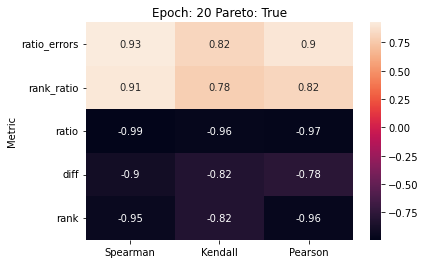

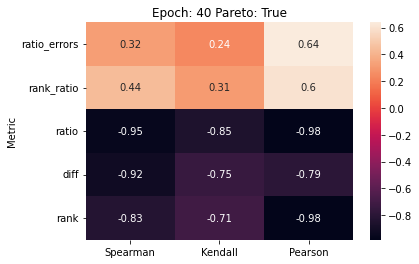

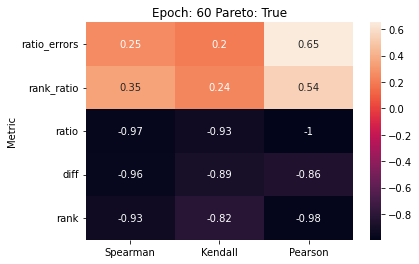

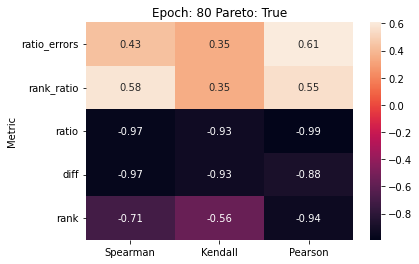

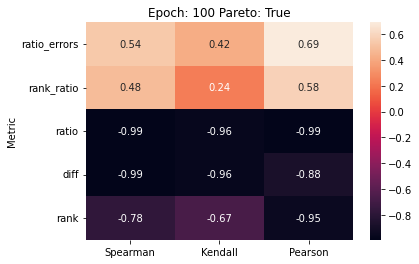

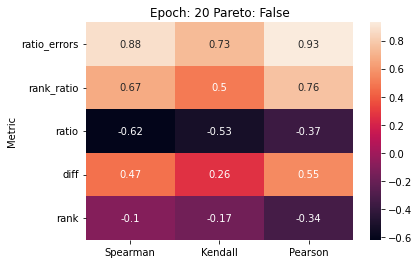

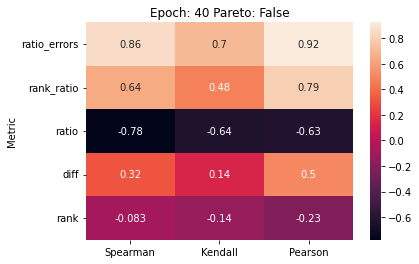

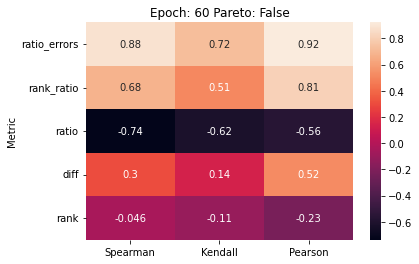

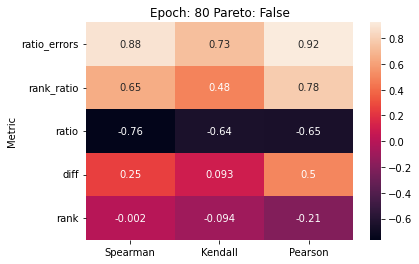

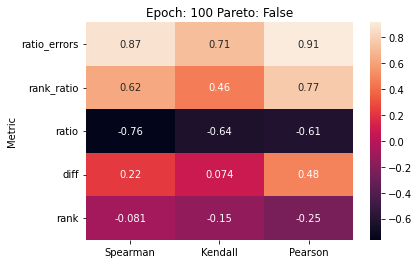

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
pareto_list = [True,False]
epoch_list = [19,39,59,79,99]
for pareto in pareto_list:
    for epoch in epoch_list:
        df_corr_99 =df_correlations[df_correlations["Epoch"]==epoch]
        df_corr_99_pareto = df_corr_99[df_corr_99["Pareto"]==pareto]
        df_corr_99_pareto.drop("Epoch",inplace=True,axis=1)
        df_corr_99_pareto.drop("Pareto",inplace=True,axis=1)
        df_corr_99_pareto.index = df_corr_99_pareto["Metric"]
        df_corr_99_pareto.drop("Metric",inplace=True,axis=1)
        ax = plt.axes()
        sns.heatmap(df_corr_99_pareto, annot=True)
        ax.set_title('Epoch: '+str(epoch+1)+' Pareto: '+str(pareto))
        plt.show()